# Accumulated Local Effects (ALE) plots

In [1]:
#!pip install scikit-learn==1.0.1

In [166]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

You may need to install the Alibi library.

In [22]:
#!pip install --user alibi

In [120]:
from sklearn.datasets import fetch_california_housing, load_boston
import numpy as np
from alibi.explainers import ALE, plot_ale

data = fetch_california_housing()

In [121]:
X = data.data
y = data.target

print(f'Features: {data.feature_names}')
print(f'Label: {data.target_names}')

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Label: ['MedHouseVal']


In [122]:
data.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [124]:
lr_reg = LinearRegression()

lr_reg.fit(X_train, y_train)

LinearRegression()

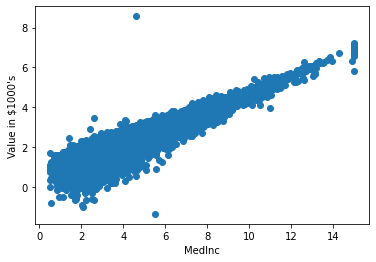

In [131]:
FEATURE = 'MedInc'
feature_names = data.feature_names
index = feature_names.index(FEATURE)

fig, ax = plt.subplots()
ax.scatter(X_train[:, index], lr_reg.predict(X_train));

ax.set_xlabel(FEATURE);
ax.set_ylabel('Value in $1000\'s');

In [132]:
lr_reg.coef_[index]

0.4390910418774263

In [133]:
lr_ale = ALE(lr_reg.predict,
             feature_names=feature_names,
             target_names=['MedHouseVal'])

In [134]:
lr_exp = lr_ale.explain(X_train)

In [135]:
len(lr_exp.ale_values[index])

361

array([[<AxesSubplot:xlabel='MedInc', ylabel='ALE'>]], dtype=object)

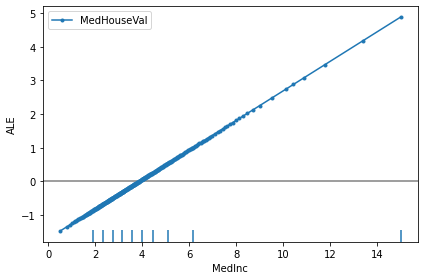

In [136]:
plot_ale(lr_exp, features=[FEATURE])

For MedInc = 12, the ALE value is 3.47

In [137]:
lr_exp.ale_values[index][-3]

array([3.47184384])

Take the examples in `X_train` that a have `MedInc` close to 12 and compute the average of the model predictions on this subset. 

In [143]:
lower_index = np.where(lr_exp.feature_values[index] < 12)[0][-1]
upper_index = np.where(lr_exp.feature_values[index] > 12)[0][0]

print(f'lower_index: {lower_index}')
print(f'upper_index: {upper_index}')

lower_index: 358
upper_index: 359


In [144]:
lr_exp.feature_values[index][358]

11.779547777777776

In [145]:
lr_exp.feature_values[index][359]

13.39159916666666

In [146]:
subset = X_train[(X_train[:, index] > lr_exp.feature_values[index][lower_index])
                 & (X_train[:, index] < lr_exp.feature_values[index][upper_index])]
print(f'shape of subset: {subset.shape}')

shape of subset: (43, 8)


In [147]:
subset_pred = lr_reg.predict(subset).mean()
subset_pred

5.79208185045512

In [148]:
mean_pred = lr_reg.predict(X_train).mean()
mean_pred

2.0743726279070067

In [149]:
subset_pred - mean_pred

3.7177092225481134

### Now for a non-linear model

In [174]:
rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, y_train)

RandomForestRegressor()

array([[<AxesSubplot:xlabel='MedInc', ylabel='ALE'>]], dtype=object)

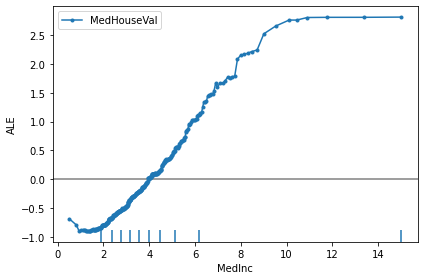

In [175]:
FEATURE = 'MedInc'
feature_names = data.feature_names
index = feature_names.index(FEATURE)

rf_ale = ALE(rf_reg.predict,
              feature_names=feature_names,
              target_names=['MedHouseVal'])
rf_exp = rf_ale.explain(X_train)
plot_ale(rf_exp, features=[FEATURE])

array([[<AxesSubplot:xlabel='MedInc', ylabel='ALE'>,
        <AxesSubplot:xlabel='HouseAge', ylabel='ALE'>,
        <AxesSubplot:xlabel='AveRooms', ylabel='ALE'>],
       [<AxesSubplot:xlabel='AveBedrms', ylabel='ALE'>,
        <AxesSubplot:xlabel='Population', ylabel='ALE'>,
        <AxesSubplot:xlabel='AveOccup', ylabel='ALE'>],
       [<AxesSubplot:xlabel='Latitude', ylabel='ALE'>,
        <AxesSubplot:xlabel='Longitude', ylabel='ALE'>, None]],
      dtype=object)

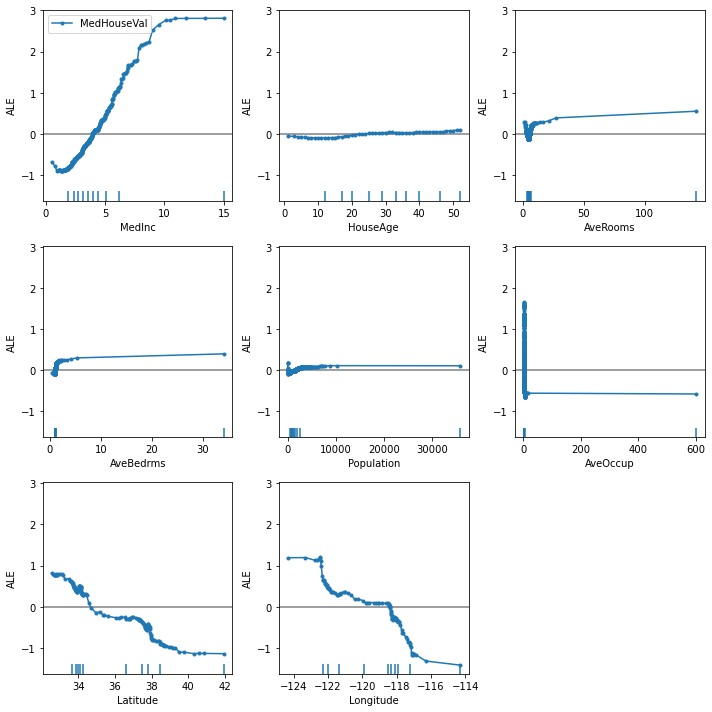

In [176]:
plot_ale(rf_exp, fig_kw={'figwidth':10, 'figheight': 10})

In [189]:
indices = rf_reg.feature_importances_.argsort()[-4:][::-1]
for ind in indices:
    print(feature_names[ind])

MedInc
AveOccup
Longitude
Latitude


### Comparing features across diffrent models

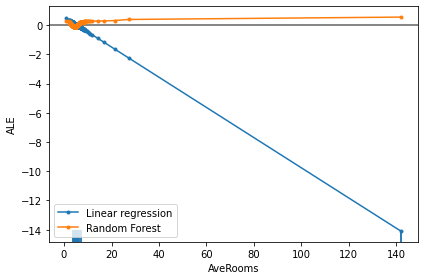

In [194]:
fig, ax = plt.subplots()
plot_ale(lr_exp, features=['AveRooms'], ax=ax, line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, features=['AveRooms'], ax=ax, line_kw={'label': 'Random Forest'});

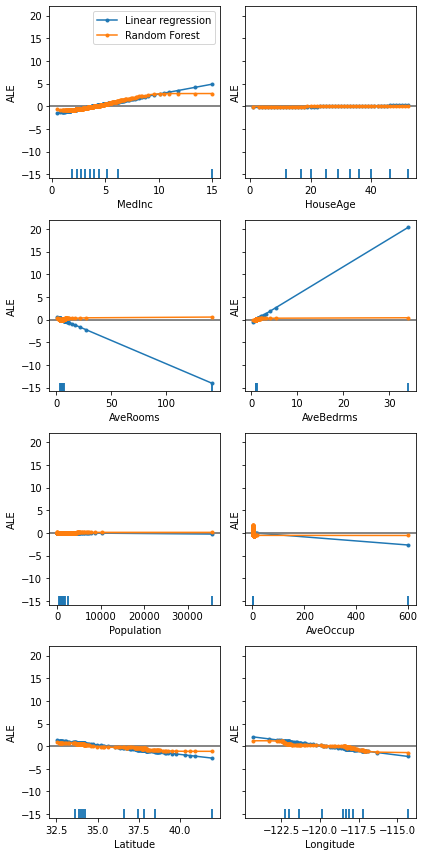

In [199]:
fig, ax = plt.subplots(4, 2, sharey='all');

plot_ale(lr_exp, ax=ax, fig_kw={'figwidth':6, 'figheight': 12},
         line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, ax=ax, line_kw={'label': 'Random Forest'});

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License